In [3]:
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import torch
from PIL import Image

# Load the model
loaded_model = torch.jit.load("colorization_model_scripted.pt")
loaded_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Model loaded successfully")

Model loaded successfully


Resized Image Shape: (128, 128, 3)


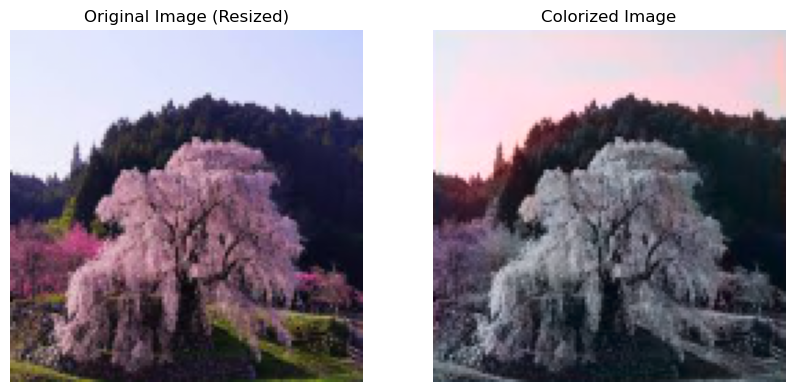

In [4]:

# Assuming you've loaded the model as you did before
def test_and_visualize1(image, model):
    device = torch.device('cpu')
    model.eval()

    # If the image has an alpha channel (RGBA), remove it
    if image.shape[-1] == 4:
        image = image[:, :, :3]  # Keep only the RGB channels

    # Ensure the image has the correct shape (height, width, 3)
    if image.shape[0] == 3:  # The image is in (channels, height, width) format
        image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)

    # Resize the image to 128x128
    image_resized = resize(image, (128, 128), mode='reflect', anti_aliasing=True)

    # Check the resized image shape
    print(f"Resized Image Shape: {image_resized.shape}")

    # Preprocess the resized image
    img = torch.tensor(image_resized).to(device).float() / 255.0  # Normalize to [0, 1]
    
    # Convert RGB to LAB and extract the L channel
    L = rgb2lab(image_resized)[:, :, 0]
    L = torch.tensor(L).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

    # Repeat L channel to create 3-channel input for the encoder
    L_pseudo_rgb = L.repeat(1, 3, 1, 1)  # Shape (1, 3, 128, 128)

    with torch.no_grad():
        ab = model(L_pseudo_rgb).cpu().numpy()[0].transpose(1, 2, 0) * 128

    # Combine L and AB channels
    lab = np.zeros((128, 128, 3))
    lab[:, :, 0] = L.squeeze().cpu().numpy()
    lab[:, :, 1:] = ab
    colorized = lab2rgb(lab)

    # Display the original and colorized images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image_resized)
    ax[0].set_title("Original Image (Resized)")
    ax[0].axis("off")

    ax[1].imshow(colorized)
    ax[1].set_title("Colorized Image")
    ax[1].axis("off")

    plt.show()

# Load and test the model with an image
image = plt.imread('sak_tee.jpg')  # Use your input image
test_and_visualize1(image, loaded_model)


In [5]:


def histogram_stretching(image):
    """
    Apply histogram stretching to an image (L channel of LAB).
    The values are scaled to the range [0, 100] for the L channel.
    """
    # Stretch the image: map min to 0, max to 100 for L channel
    min_val = np.min(image)
    max_val = np.max(image)
    stretched = 100 * (image - min_val) / (max_val - min_val)  # Stretch to [0, 100]
    return stretched

def plot_histogram(image, ax, title):
    """
    Plot the histogram for the given image (in RGB format).
    """
    ax.hist(image.ravel(), bins=256, color='gray', alpha=0.5)
    ax.set_title(title)
    ax.set_xlim([0, 1])  # For normalized images
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')

def test_and_visualize2(image, model):
    device = torch.device('cpu')
    model.eval()

    # If the image has an alpha channel (RGBA), remove it
    if image.shape[-1] == 4:
        image = image[:, :, :3]  # Keep only the RGB channels

    # Ensure the image has the correct shape (height, width, 3)
    if image.shape[0] == 3:  # The image is in (channels, height, width) format
        image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)

    # Resize the image to 128x128
    image_resized = resize(image, (128, 128), mode='reflect', anti_aliasing=True)

    # Preprocess the resized image
    img = torch.tensor(image_resized).to(device).float() / 255.0  # Normalize to [0, 1]
    
    # Convert RGB to LAB and extract the L channel
    L = rgb2lab(image_resized)[:, :, 0]
    L = torch.tensor(L).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

    # Repeat L channel to create 3-channel input for the encoder
    L_pseudo_rgb = L.repeat(1, 3, 1, 1)  # Shape (1, 3, 128, 128)

    with torch.no_grad():
        ab = model(L_pseudo_rgb).cpu().numpy()[0].transpose(1, 2, 0) * 128

    # Combine L and AB channels
    lab = np.zeros((128, 128, 3))
    lab[:, :, 0] = L.squeeze().cpu().numpy()
    lab[:, :, 1:] = ab
    colorized = lab2rgb(lab)

    # Apply histogram stretching on the colorized image's L channel
    lab_stretched = lab.copy()
    lab_stretched[:, :, 0] = histogram_stretching(lab[:, :, 0])  # Stretch the L channel
    colorized_stretched = lab2rgb(lab_stretched)

    # Display the original, colorized, and stretched colorized images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image_resized)
    ax[0].set_title("Original Image (Resized)")
    ax[0].axis("off")

    ax[1].imshow(colorized_stretched)
    ax[1].set_title("Colorized Image (Light Stretched)")
    ax[1].axis("off")
    plt.show()

    # Plot histograms
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_histogram(image_resized, ax[0], "Original Image Histogram")
    plot_histogram(colorized_stretched, ax[1], "Colorized Image Histogram")
    plt.show()
    
    return image_resized, colorized_stretched

# Load and test the model with an image

In [6]:


def plot_histograms(original_image, colorized_image):
    # Split the original image and colorized image into R, G, B channels
    original_r, original_g, original_b = original_image[:,:,0], original_image[:,:,1], original_image[:,:,2]
    colorized_r, colorized_g, colorized_b = colorized_image[:,:,0], colorized_image[:,:,1], colorized_image[:,:,2]
    
    # Plot histograms for original image channels
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Original Image Histograms
    axes[0, 0].hist(original_r.flatten(), bins=256, color='red', alpha=0.7)
    axes[0, 0].set_title('Original Image - Red Channel')
    axes[0, 1].hist(original_g.flatten(), bins=256, color='green', alpha=0.7)
    axes[0, 1].set_title('Original Image - Green Channel')
    axes[0, 2].hist(original_b.flatten(), bins=256, color='blue', alpha=0.7)
    axes[0, 2].set_title('Original Image - Blue Channel')

    # Colorized Image Histograms
    axes[1, 0].hist(colorized_r.flatten(), bins=256, color='red', alpha=0.7)
    axes[1, 0].set_title('Colorized Image - Red Channel')
    axes[1, 1].hist(colorized_g.flatten(), bins=256, color='green', alpha=0.7)
    axes[1, 1].set_title('Colorized Image - Green Channel')
    axes[1, 2].hist(colorized_b.flatten(), bins=256, color='blue', alpha=0.7)
    axes[1, 2].set_title('Colorized Image - Blue Channel')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with the original and colorized images


In [7]:

def subtract_images(original_image, colorized_image):

    # Ensure both images are in the same shape
    original_image = np.array(original_image)
    colorized_image = np.array(colorized_image)
    
    # Check if images have the same dimensions
    if original_image.shape != colorized_image.shape:
        raise ValueError("The original and colorized images must have the same shape.")

    # Subtract colorized image from the original image
    difference = original_image - colorized_image
    
    # Clip values to be in the range [0, 1] to avoid negative values
    difference = np.clip(difference, 0, 1)
    
    # Display the difference image
    plt.figure(figsize=(6, 6))
    plt.imshow(difference)
    plt.title("Difference Image (Original - Colorized)")
    plt.axis('off')
    plt.show()


In [8]:

def modify_and_plot_rgb_channel(image, channel='red', factor=1.05):
    
    # Open image if a file path is provided
    if isinstance(image, str):
        image = Image.open(image)

    # Convert to NumPy array
    image_array = np.array(image)

    # Ensure the image is in RGB format (3 channels)
    if image_array.shape[-1] != 3:
        raise ValueError("Image must have 3 channels (RGB).")

    print(f"Original image shape: {image_array.shape}")
    print(f"Original image dtype: {image_array.dtype}")

    # Convert the image to float32 to avoid overflow during multiplication
    image_array = image_array.astype(np.float32)

    # If image values are in [0, 1], scale to [0, 255]
    if image_array.max() <= 1.0:
        image_array *= 255.0

    # Visualize before modifying
    print(f"Min and Max of original image: {image_array.min()}, {image_array.max()}")

    # Modify the specified channel
    if channel.lower() == 'red':
        image_array[:, :, 0] *= factor
    elif channel.lower() == 'green':
        image_array[:, :, 1] *= factor
    elif channel.lower() == 'blue':
        image_array[:, :, 2] *= factor
    else:
        raise ValueError("Invalid channel. Choose 'red', 'green', or 'blue'.")

    # Check the modified channel
    print(f"Min and Max of modified image: {image_array.min()}, {image_array.max()}")

    # Clip the values to be between 0 and 255 to avoid overflow
    image_array = np.clip(image_array, 0, 255)

    # Convert the modified image back to uint8 for proper display
    modified_image = Image.fromarray(image_array.astype(np.uint8))

    # Plot the original and modified image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Display the modified image
    ax[1].imshow(modified_image)
    ax[1].set_title(f"Modified Image ({channel.capitalize()} Channel)")
    ax[1].axis("off")

    plt.show()
    return np.array(modified_image)



In [9]:
def histogram_colorstretching(image,factor=.9):
    """
    Apply histogram stretching to an image (L channel of LAB).
    The values are scaled to the range [0, 100] for the L channel.
    """
    # Stretch the image: map min to 0, max to 100 for L channel
    min_val = np.min(image)
    max_val = np.max(image)
    stretched = factor * (image - min_val) / (max_val - min_val)  #
    return stretched


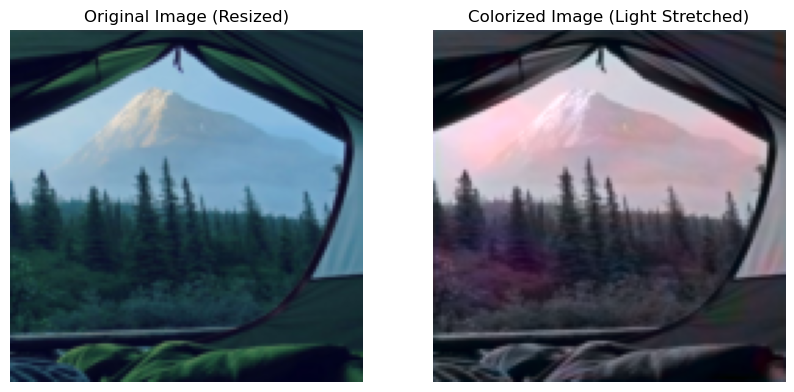

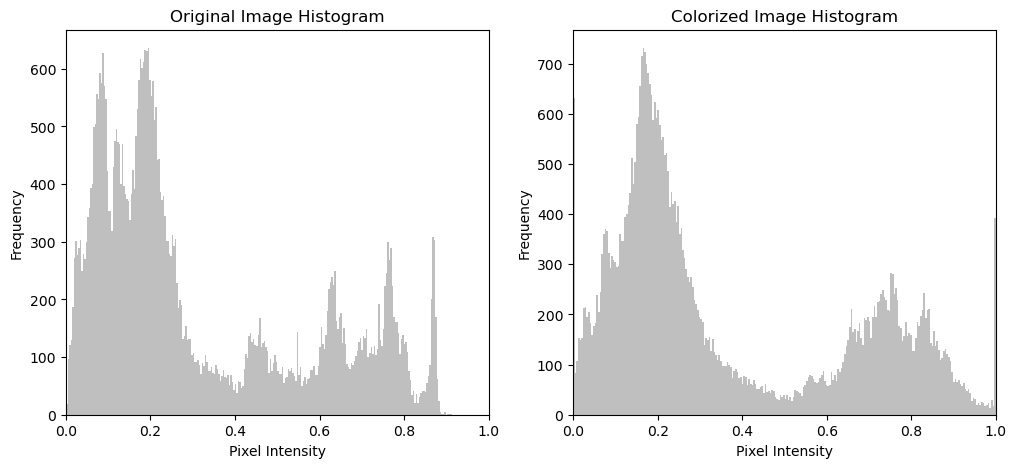

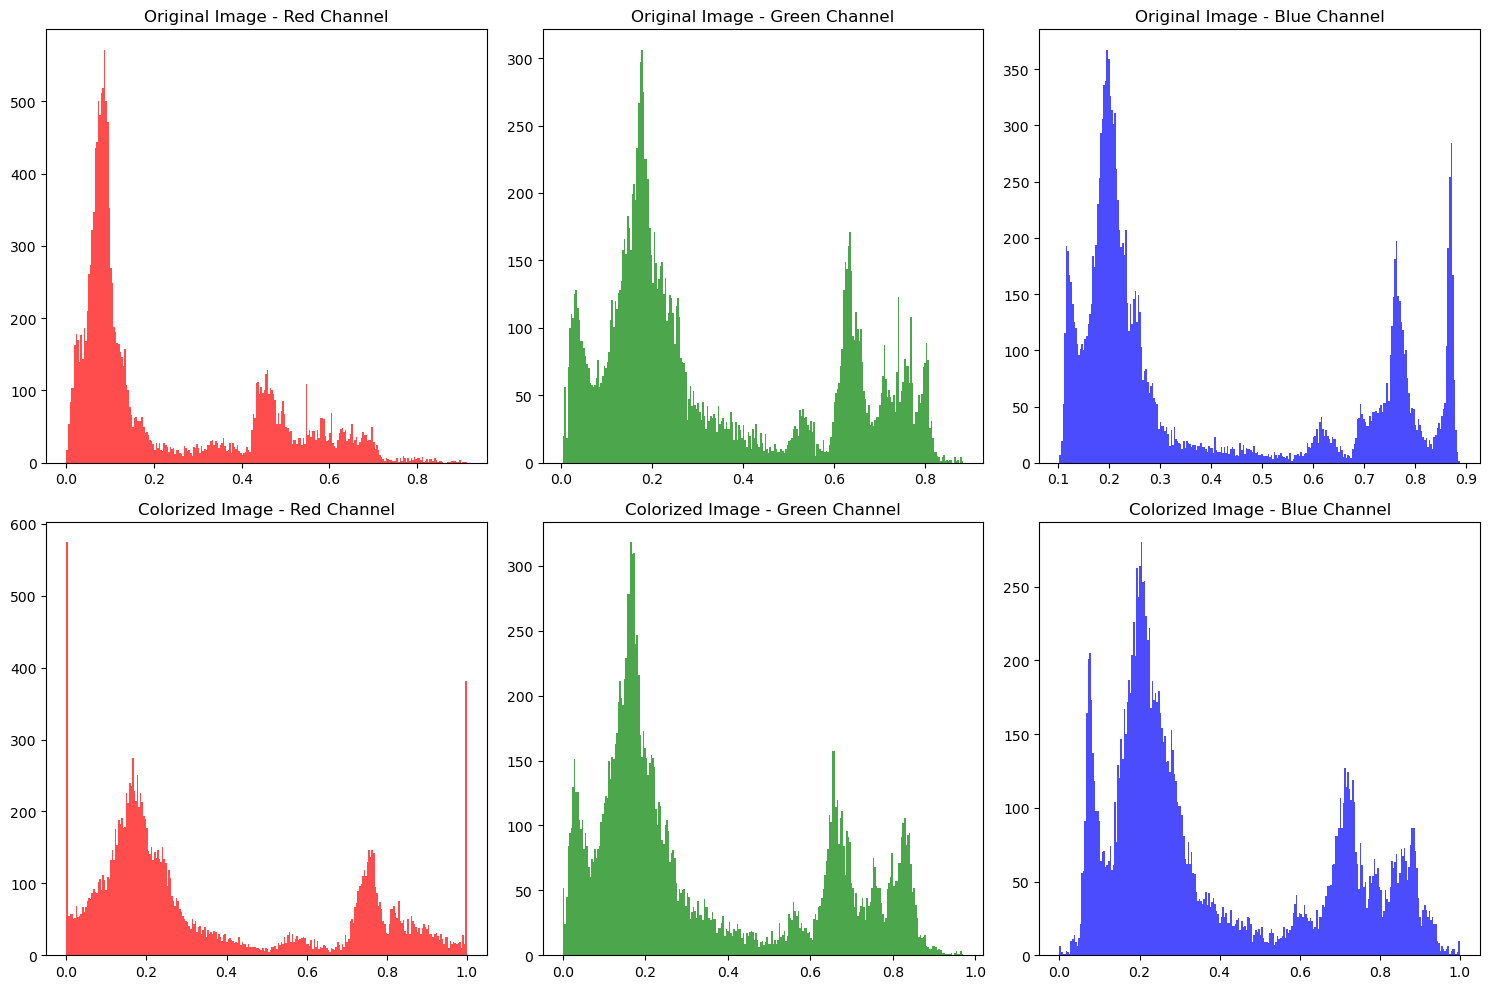

Original image shape: (128, 128, 3)
Original image dtype: float64
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 306.0


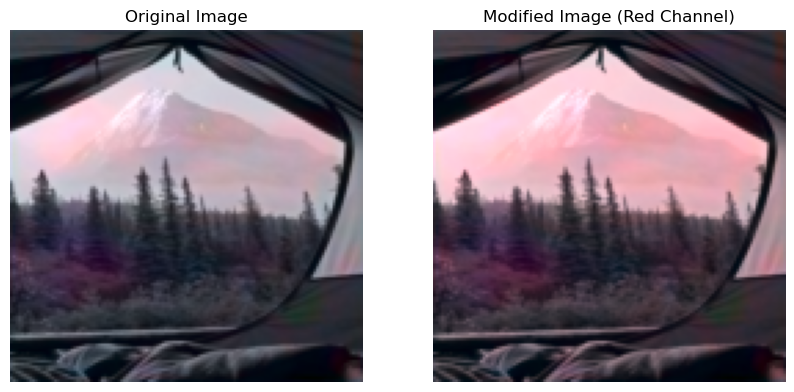

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 284.04998779296875


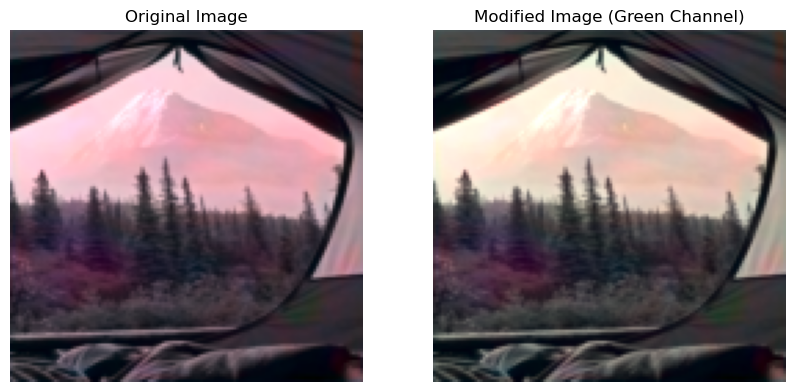

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 344.25


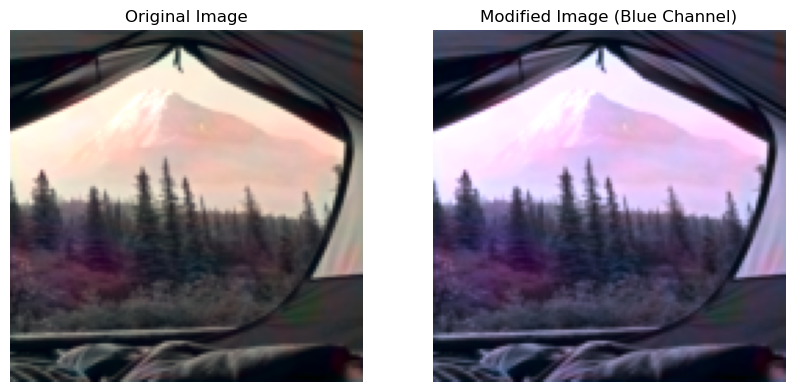

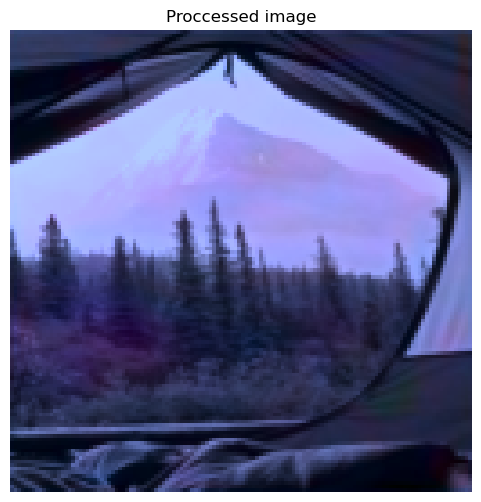

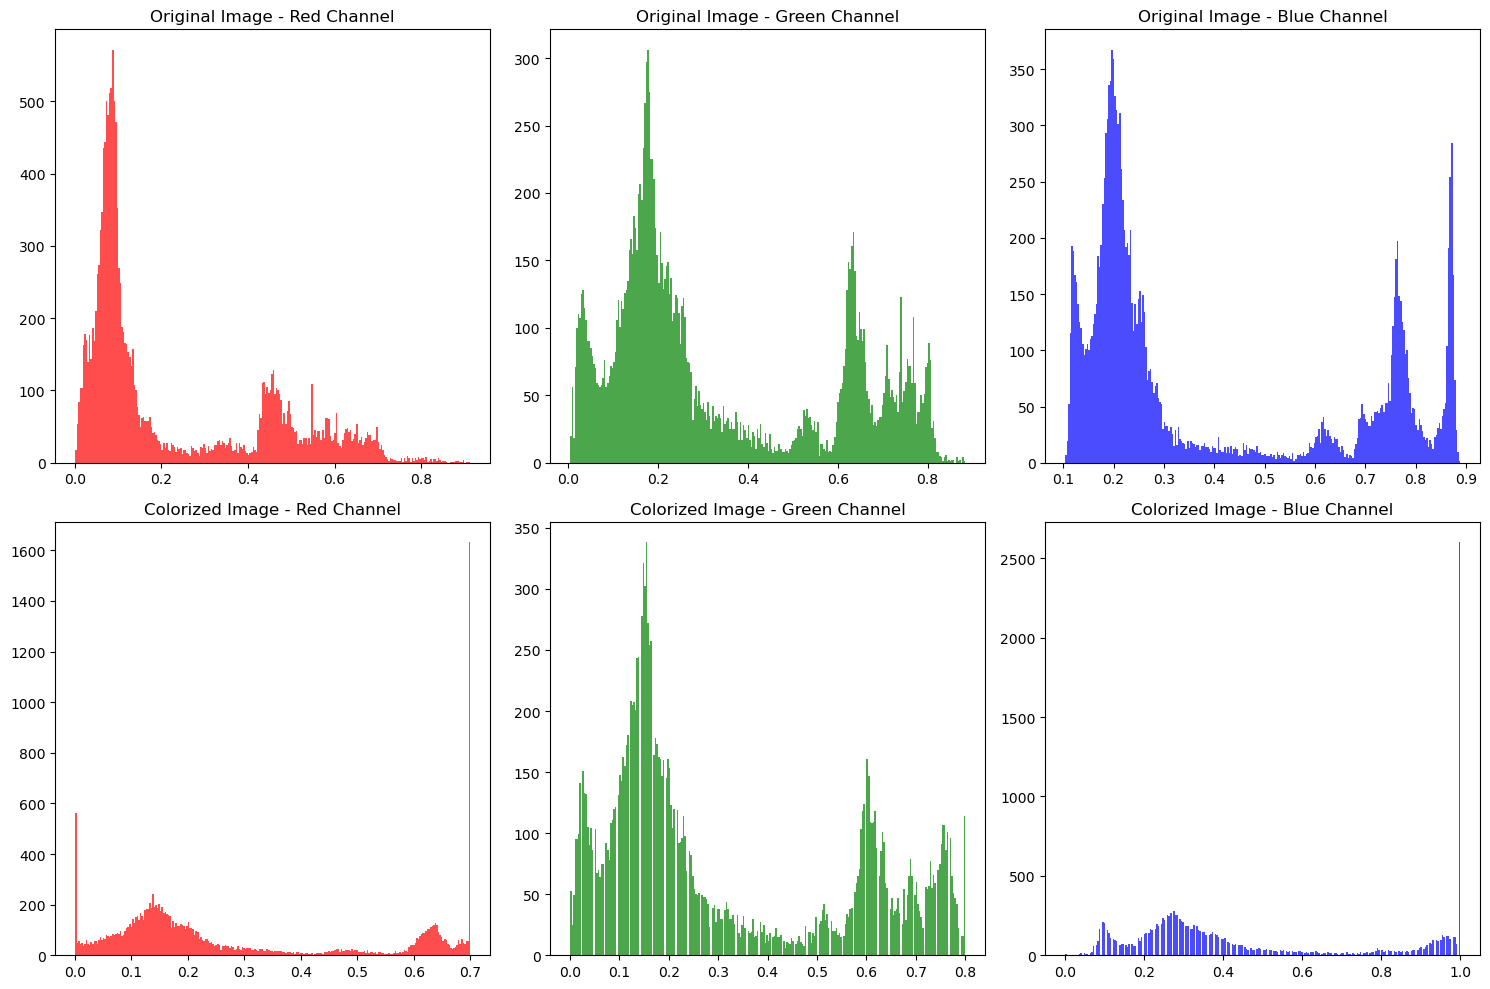

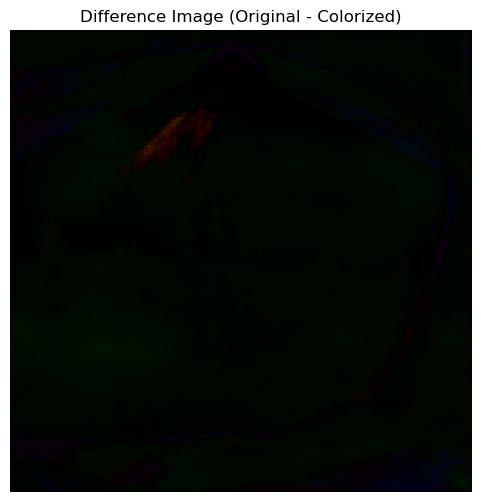

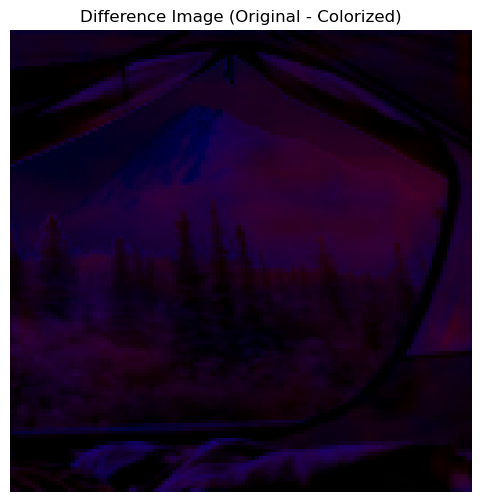

In [11]:
def postprocess(image_path, fr, fg, fb, sr, sg, sb): #Driver function calls all of the above
    image2 = plt.imread(image_path)  # Use your input image
    origin2, color2 = test_and_visualize2(image2, loaded_model)
    plot_histograms(origin2, color2)
    R_i2 = modify_and_plot_rgb_channel(color2, channel='red', factor=fr)
    RG_i2 = modify_and_plot_rgb_channel(R_i2, channel='green', factor=fg)
    RGB_i2 = modify_and_plot_rgb_channel(RG_i2, channel='blue', factor=fb)
    
    
    color_stretched2=np.zeros((128,128,3))
    color_stretched2[:,:,0]=histogram_colorstretching(RGB_i2[:,:,0], sr)
    color_stretched2[:,:,1]=histogram_colorstretching(RGB_i2[:,:,1], sg)
    color_stretched2[:,:,2]=histogram_colorstretching(RGB_i2[:,:,2], sb)

    plt.figure(figsize=(6, 6))
    plt.imshow(color_stretched2)
    plt.title("Proccessed image")
    plt.axis('off')
    plt.show()
    plot_histograms(origin2, color_stretched2)
    subtract_images(origin2, color_stretched2)
    subtract_images( color_stretched2,origin2)
postprocess('landscape2.jpg',1.2,1.15,1.35,.7,.8,1)

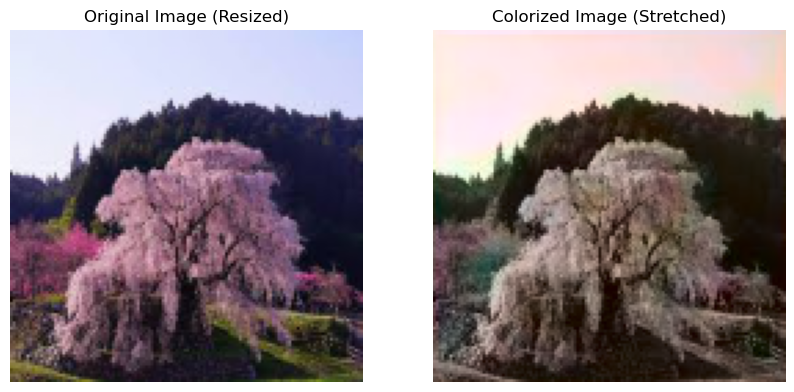

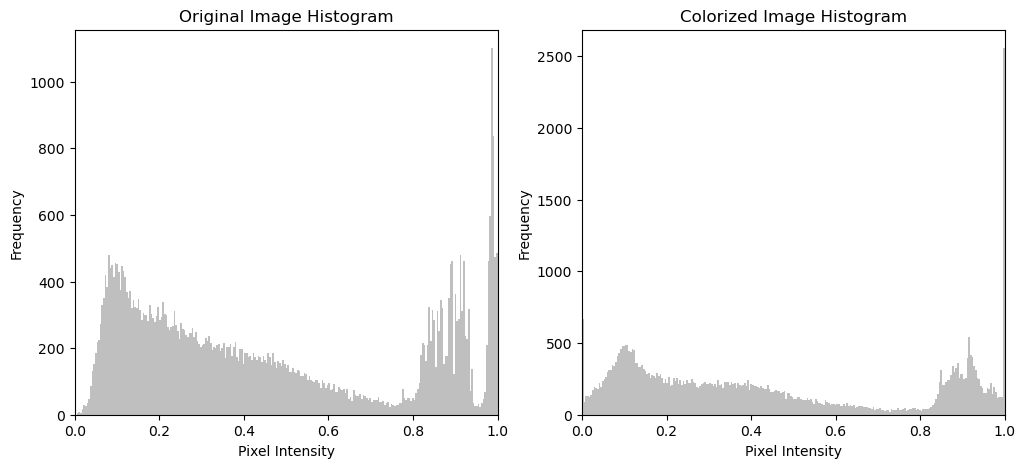

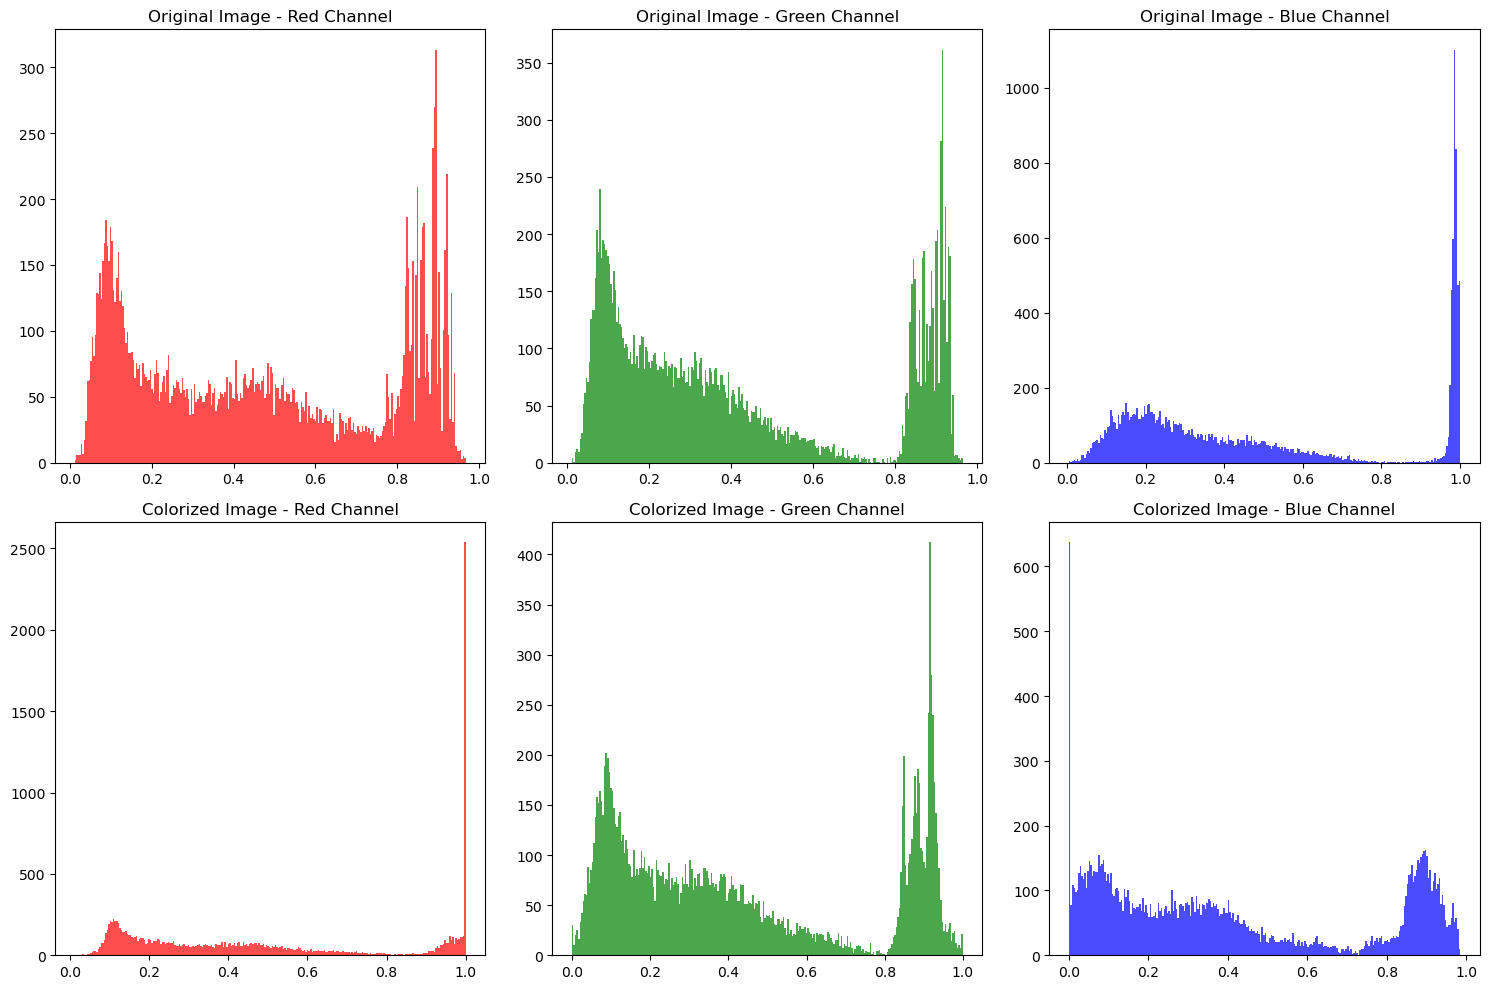

Original image shape: (128, 128, 3)
Original image dtype: float64
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 283.0500183105469


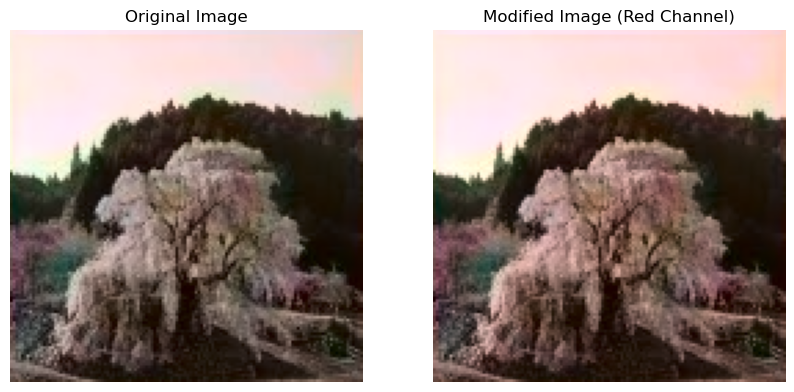

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 255.0


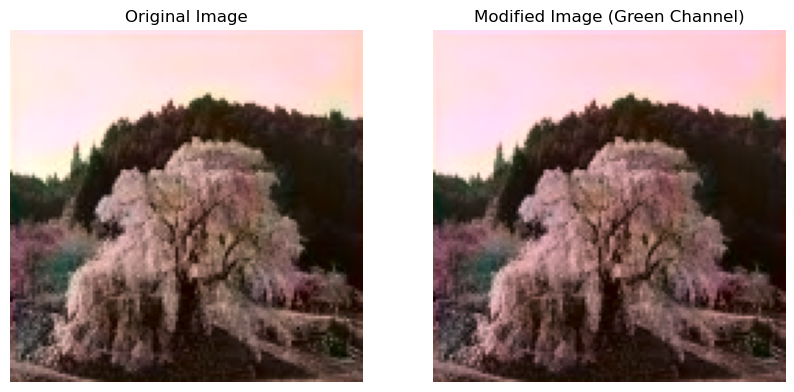

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 255.0


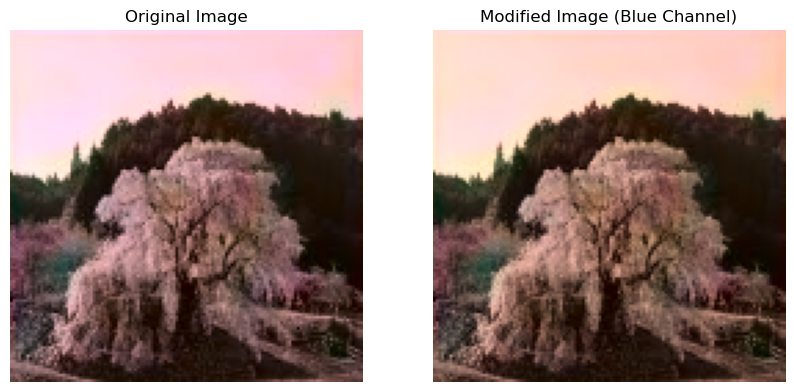

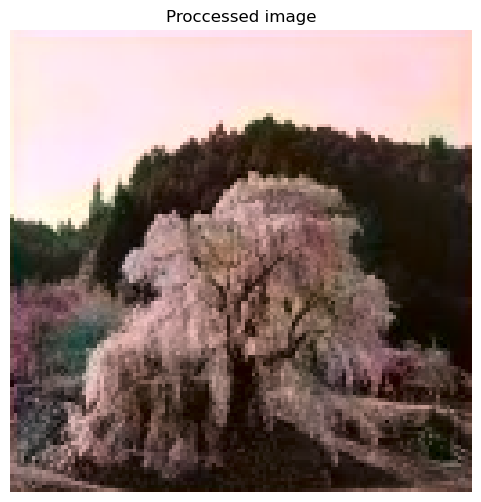

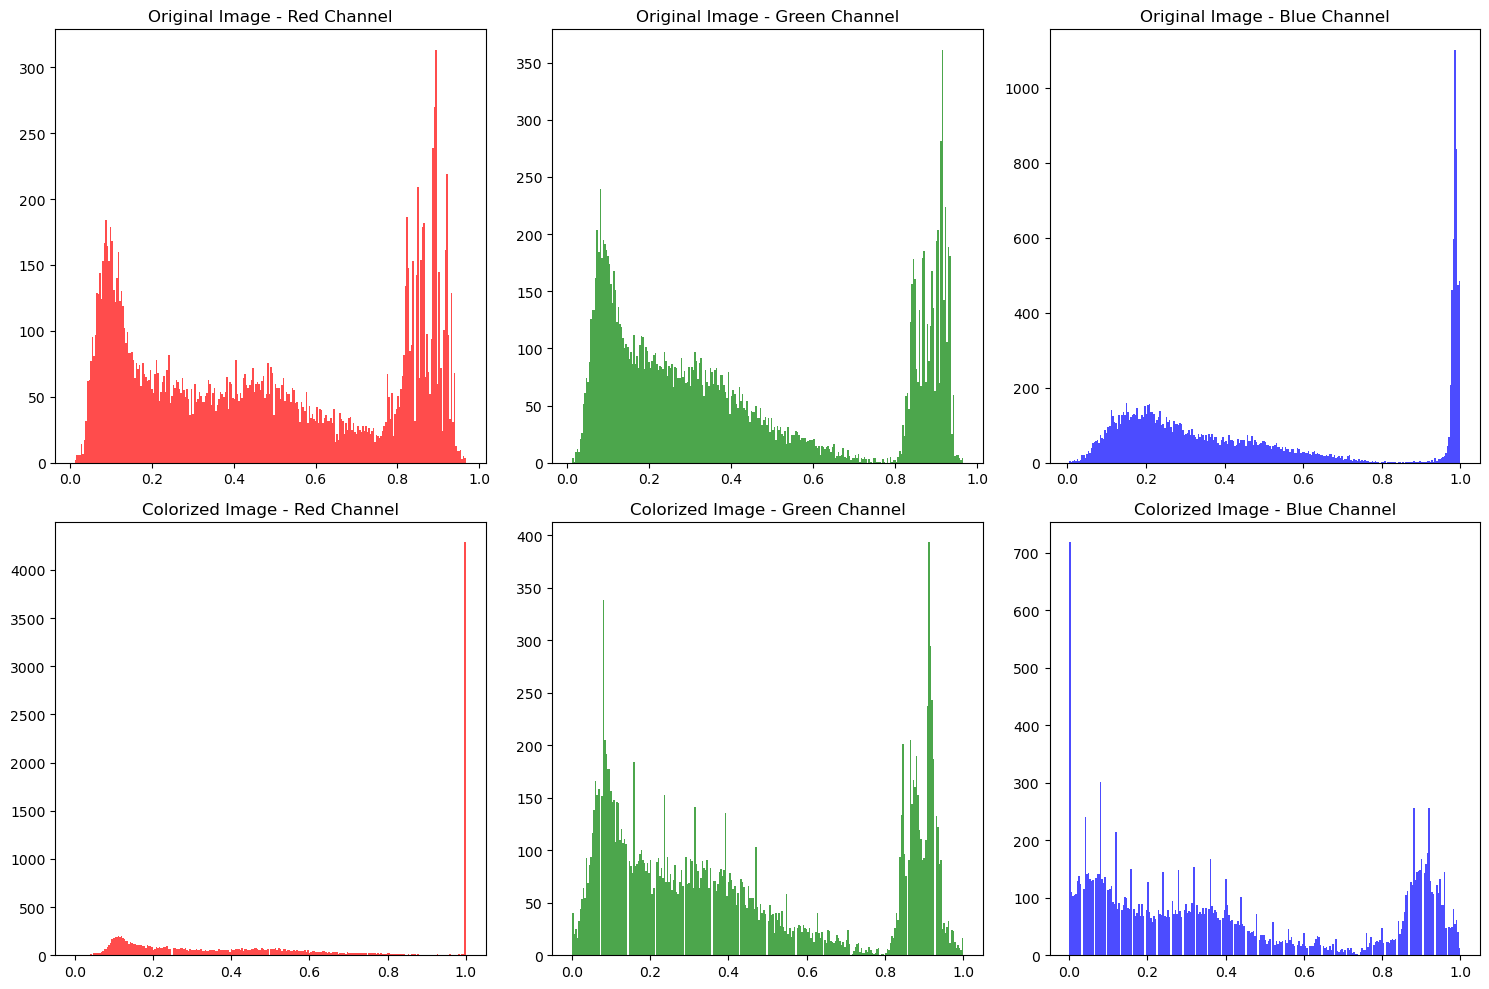

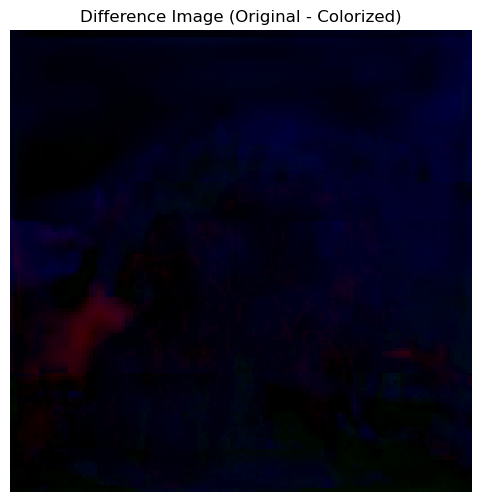

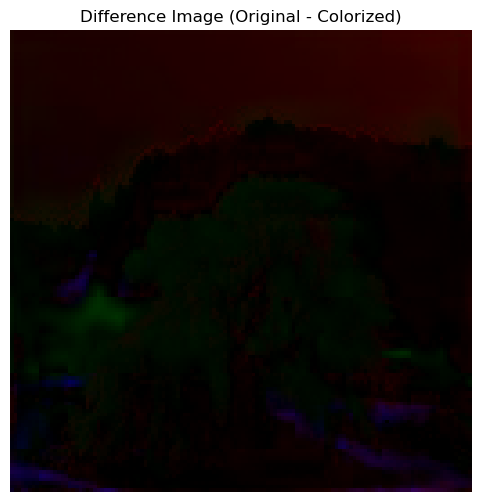

In [229]:
postprocess('sak_tee.jpg',1.11,.95,.9,1,1,1)

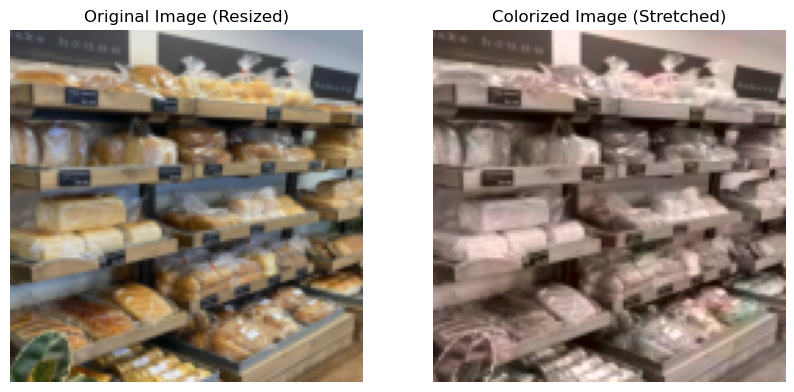

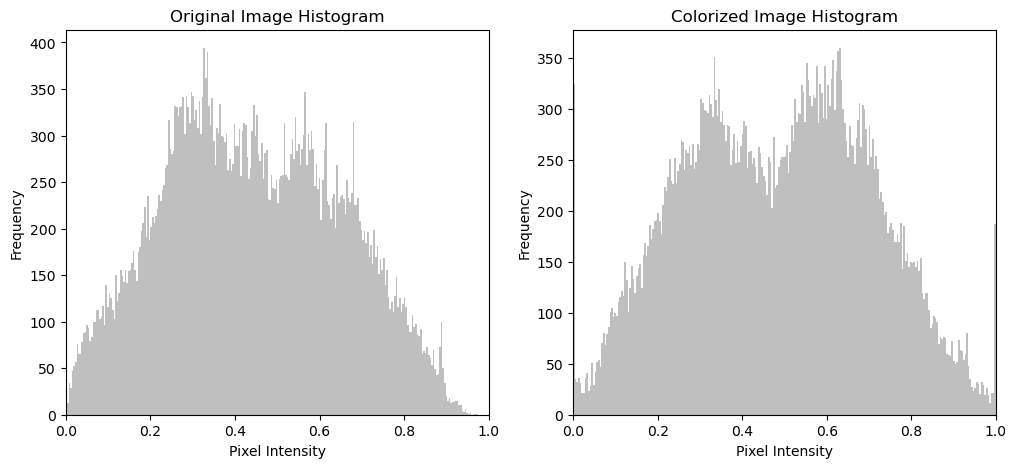

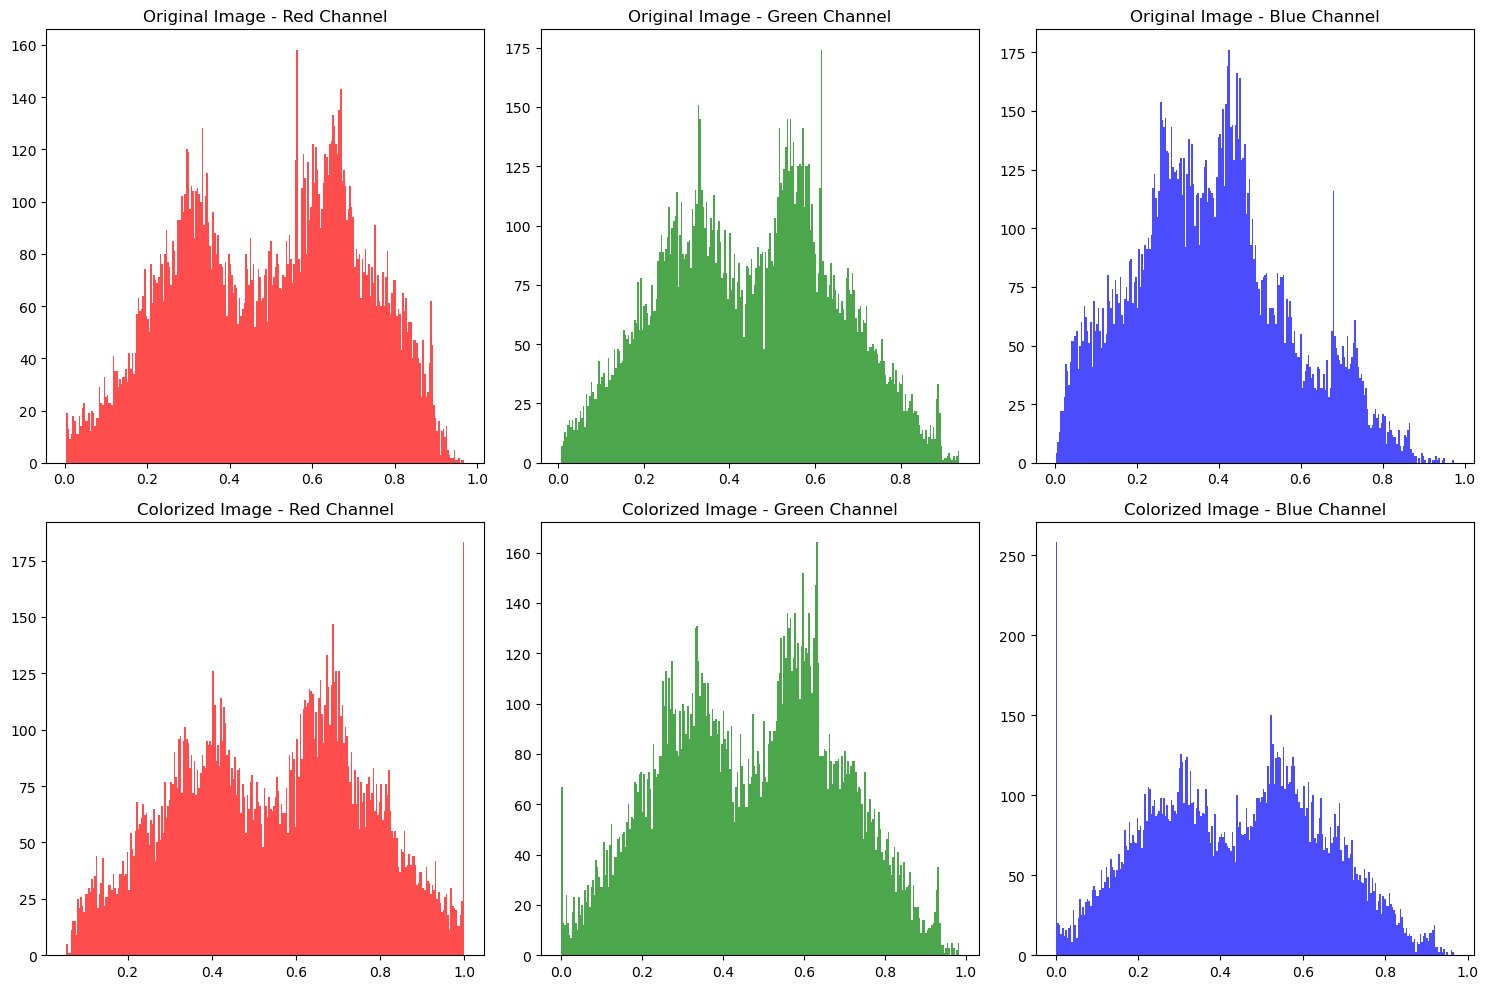

Original image shape: (128, 128, 3)
Original image dtype: float64
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 255.0


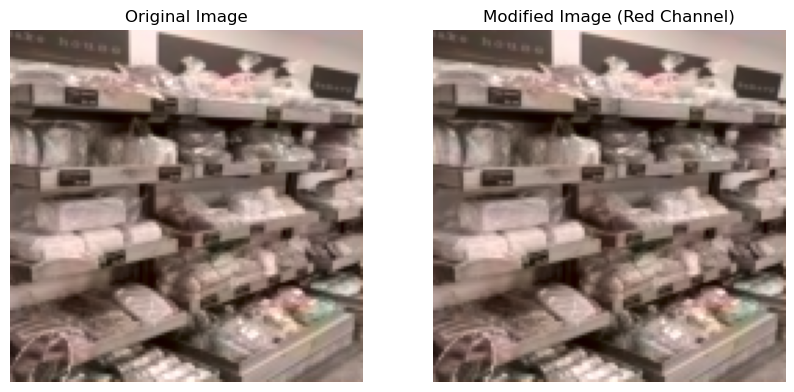

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 275.0


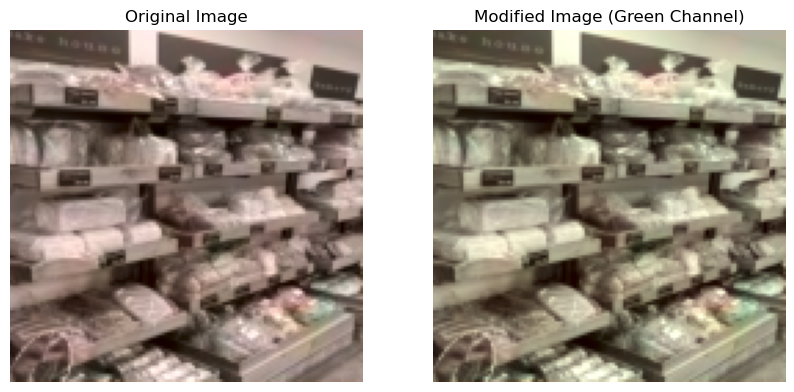

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 255.0


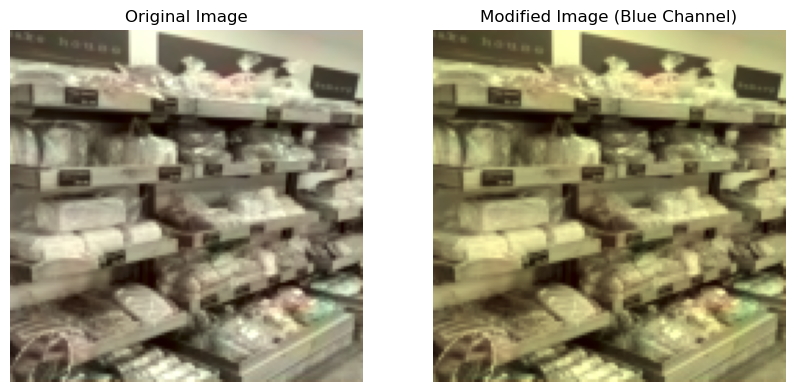

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


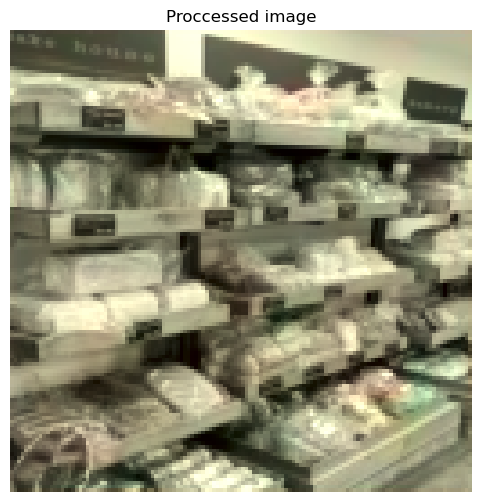

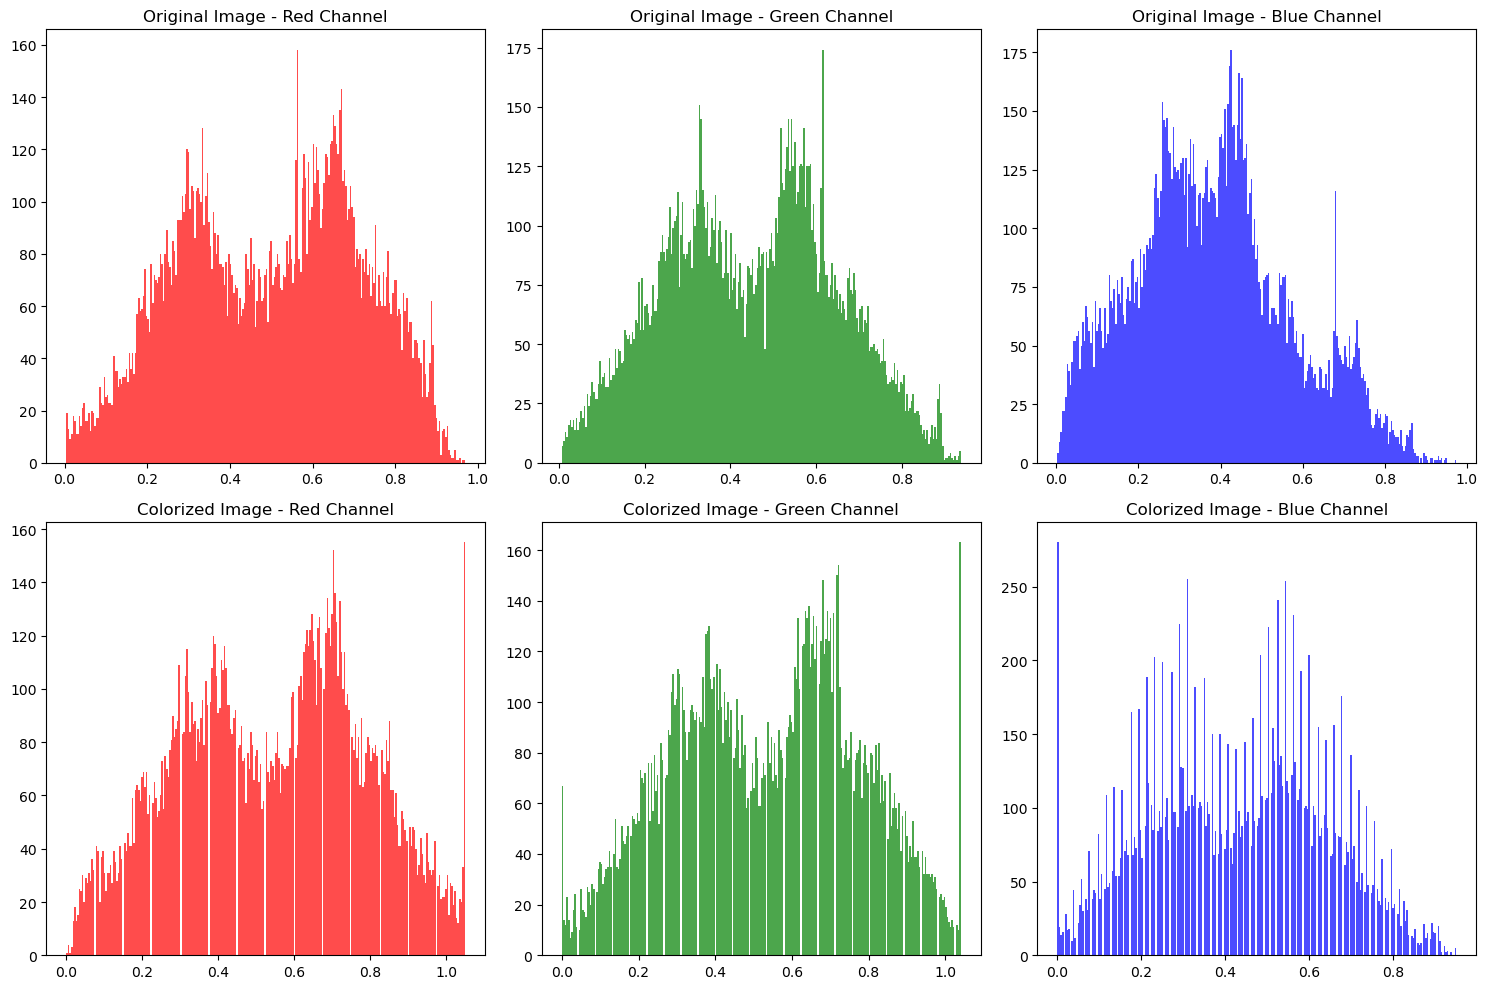

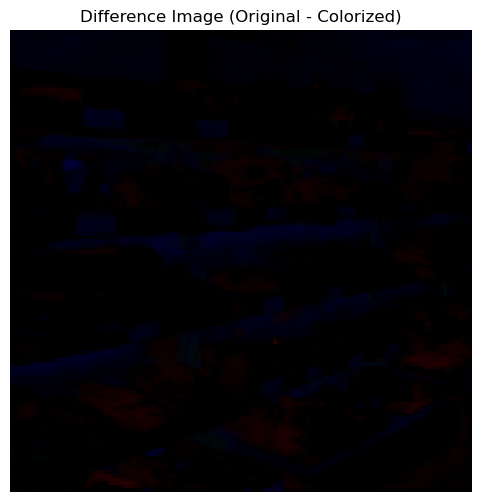

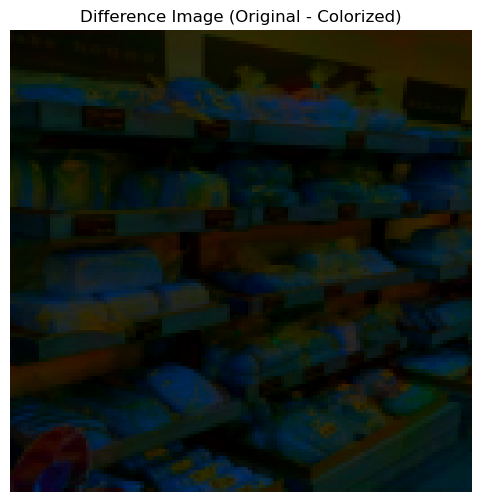

In [233]:
postprocess('bread1.jpg',1,1.1,.8,1.05,1.04,.95)

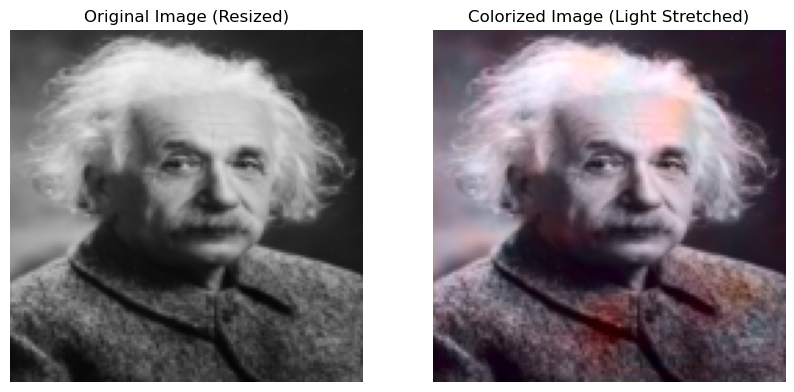

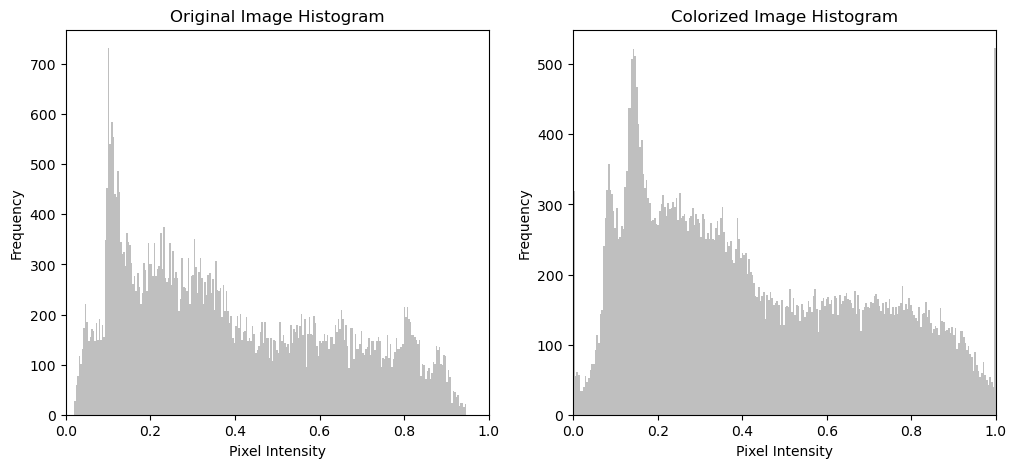

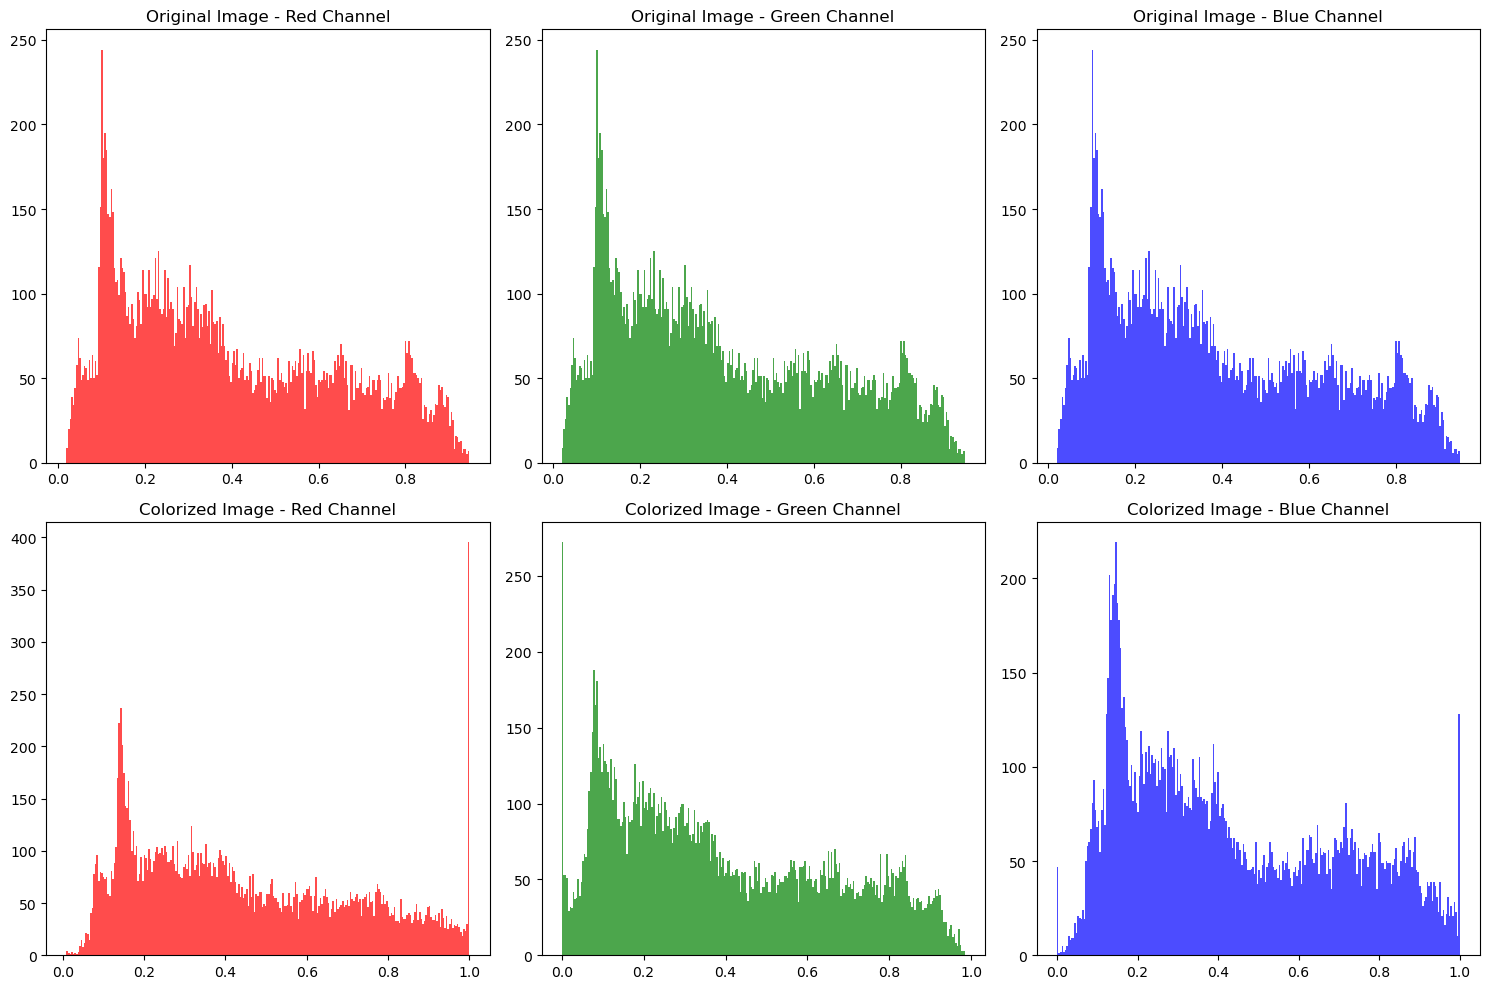

Original image shape: (128, 128, 3)
Original image dtype: float64
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 262.6499938964844


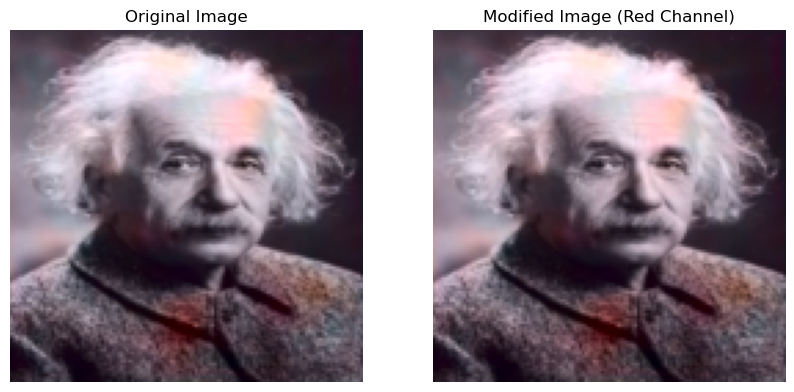

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 275.0


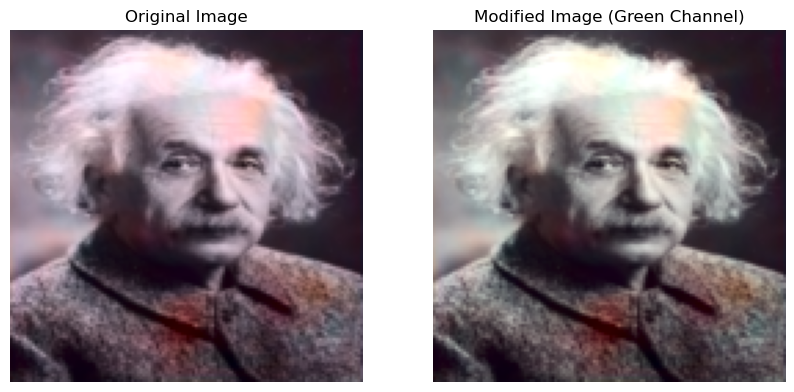

Original image shape: (128, 128, 3)
Original image dtype: uint8
Min and Max of original image: 0.0, 255.0
Min and Max of modified image: 0.0, 267.75


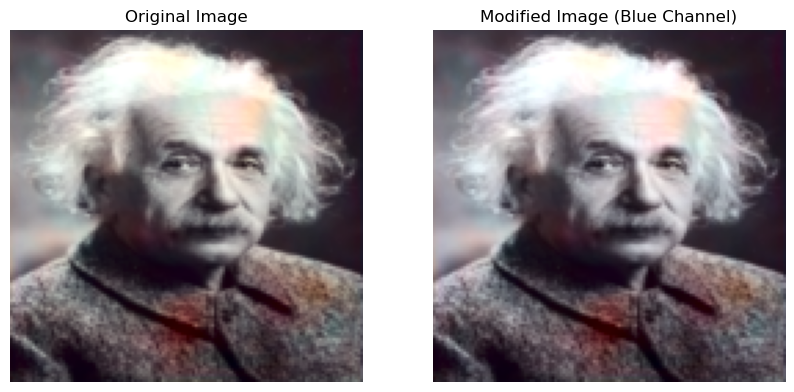

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


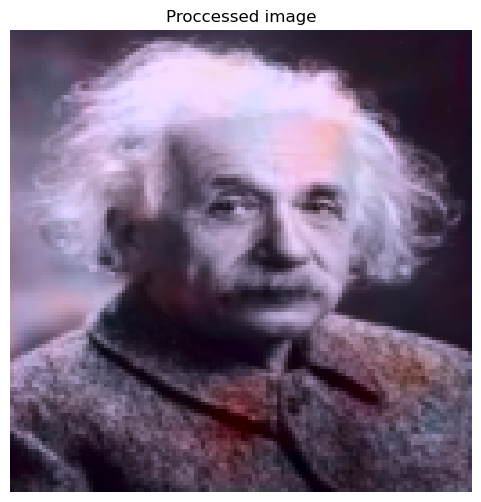

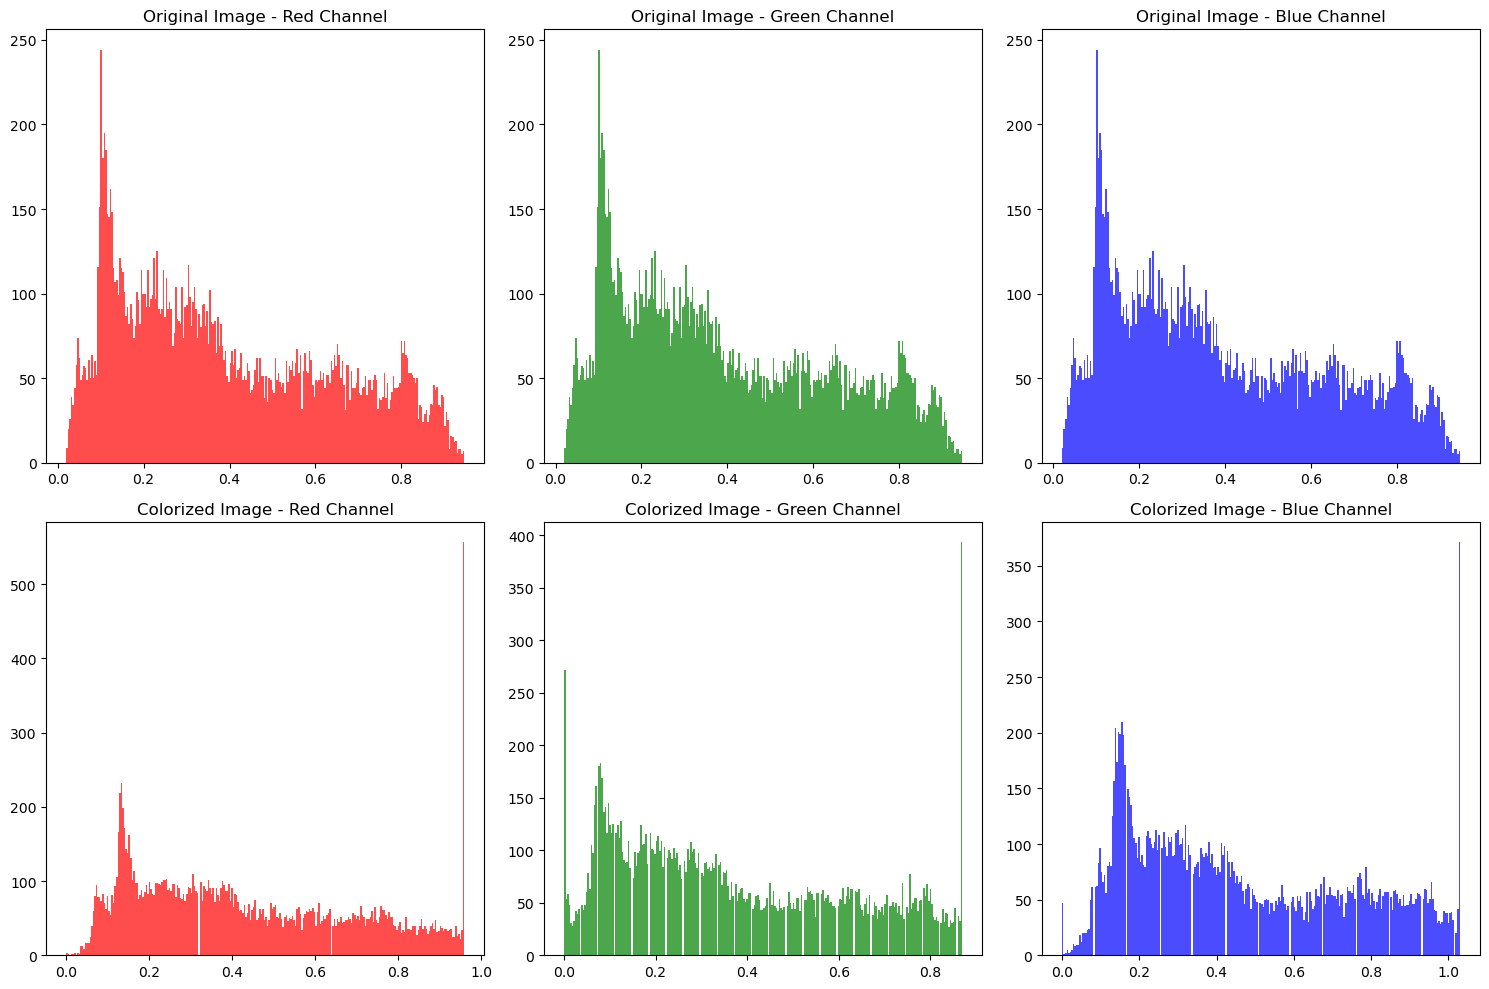

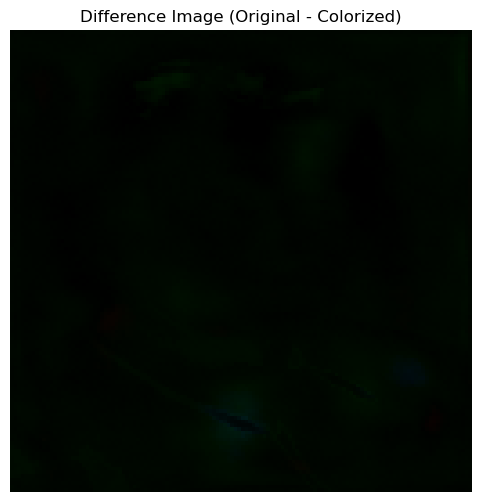

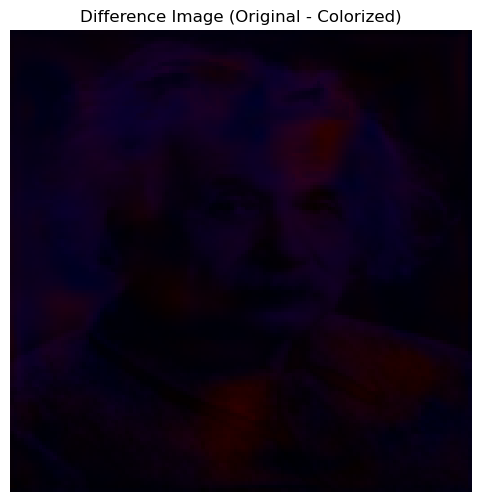

In [24]:
postprocess('AlbertEinstein.jpeg',1.03,1.1,1.05,.96,.87,1.03)